### import

In [2]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# 그래프
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import networkx as nx
from pyvis.network import Network

from collections import Counter
# from wordcloud import WordCloud
from glob import glob
import os 
from google.cloud import bigquery


import warnings
warnings.filterwarnings("ignore")


C:\Users\MAEIL\AppData\Local\Programs\Python\Python311\Lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


### data load

In [3]:
df1 = pd.read_excel('./20230516_review_data5_before.xlsx', 0, engine="openpyxl")

In [4]:
df2 = pd.read_excel('./20230515_review_data.xlsx', 1, engine="openpyxl")

In [26]:
len(df1), len(df2)

(1533, 189)

In [45]:
min(df2['리뷰등록일']), max(df2['리뷰등록일'])

(Timestamp('2023-04-19 15:22:40'), Timestamp('2023-05-15 12:56:00'))

In [7]:
def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()
    return str1

In [9]:
doc1 = listToString(df1[df1['리뷰상세내용'].str.contains(' ')]['리뷰상세내용'])
doc2 = listToString(df2[df2['리뷰상세내용'].str.contains(' ')]['리뷰상세내용'])

In [10]:
# 사전에 고유 명사 추가
twitter.add_dictionary('콜드브루', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('오트밀크', 'Noun')
twitter.add_dictionary('종이빨대', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('서울우유', 'Noun')
twitter.add_dictionary('매일두유', 'Noun')
twitter.add_dictionary('바리스타', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('어메이징 오트', 'Noun')
twitter.add_dictionary('어메이징오트', 'Noun')
twitter.add_dictionary('언스위트', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('아몬드 브리즈', 'Noun')
twitter.add_dictionary('오리지널', 'Noun')
twitter.add_dictionary('오리지날', 'Noun')
twitter.add_dictionary('언스윗트', 'Noun')
twitter.add_dictionary('의향', 'Noun')
twitter.add_dictionary('꿀맛', 'Noun')
twitter.add_dictionary('에스프레소', 'Noun')
twitter.add_dictionary('라떼', 'Noun')
twitter.add_dictionary('홈카페', 'Noun')
twitter.add_dictionary('바리스타', 'Noun')
twitter.add_dictionary('대용량', 'Noun')
twitter.add_dictionary('고소하', 'Noun')
twitter.add_dictionary('재발송', 'Noun')
twitter.add_dictionary('풍미', 'Noun')
twitter.add_dictionary('라테', 'Noun')
twitter.add_dictionary('에스프레스', 'Noun')
twitter.add_dictionary('큰팩', 'Noun')
twitter.add_dictionary('스벅', 'Noun')
twitter.add_dictionary('대용품', 'Noun')
twitter.add_dictionary('식물성', 'Noun')
twitter.add_dictionary('은은한', 'Noun')
twitter.add_dictionary('고소한', 'Noun')
twitter.add_dictionary('본연의', 'Noun')
twitter.add_dictionary('뽁뽁이', 'Noun')
twitter.add_dictionary('쇼핑백', 'Noun')
twitter.add_dictionary('브랜드데이', 'Noun')
twitter.add_dictionary('카톡딜', 'Noun')
twitter.add_dictionary('콘프라이트', 'Noun')
twitter.add_dictionary('달작지근하다', 'Verb')
twitter.add_dictionary('선식', 'Noun')
twitter.add_dictionary('고지혈', 'Noun')
twitter.add_dictionary('가성비', 'Noun')
twitter.add_dictionary('당뇨', 'Noun')
twitter.add_dictionary('찐한', 'Noun')
twitter.add_dictionary('홀더', 'Noun')
twitter.add_dictionary('투에프엘', 'Noun')
twitter.add_dictionary('분수토', 'Noun')
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('화이버', 'Noun')
twitter.add_dictionary('장건강', 'Noun')
twitter.add_dictionary('장트러블', 'Noun')
twitter.add_dictionary('대변', 'Noun')
twitter.add_dictionary('배변', 'Noun')
twitter.add_dictionary('굿즈', 'Noun')
twitter.add_dictionary('문별', 'Noun')
twitter.add_dictionary('콤부차', 'Noun')
twitter.add_dictionary('레몬', 'Noun')

In [12]:
tokenized_doc1 = twitter.nouns(doc1)
tokenized_doc2 = twitter.nouns(doc2)

In [13]:
stopwords = ['어요', '오리', '어서', '하니', ]

In [14]:
for word in tokenized_doc1:  # iterating on a copy since removing will mess things up
    if word in stopwords:
        tokenized_doc1.remove(word)

In [15]:
for word in tokenized_doc2:  # iterating on a copy since removing will mess things up
    if word in stopwords:
        tokenized_doc2.remove(word)

In [20]:
wordfreq = {}
for word in listToString(tokenized_doc1).replace(', ',' ').split():
    wordfreq[word] = wordfreq.setdefault(word, 0) + 1
    
df1_wordcount = pd.DataFrame.from_dict([wordfreq]).T.reset_index()
df1_wordcount.rename(columns = {0 : 'count', 'index' : 'words'}, inplace =True)
df1_wordcount = df1_wordcount.sort_values(by = 'count', axis=0, ascending=False).reset_index()
df1_wordcount = df1_wordcount[['words', 'count']]

df1_wordcount['LEN'] = df1_wordcount['words'].str.len()
df1_wordcount = df1_wordcount[df1_wordcount['LEN'] >= 2]

In [21]:
wordfreq = {}
for word in listToString(tokenized_doc2).replace(', ',' ').split():
    wordfreq[word] = wordfreq.setdefault(word, 0) + 1
    
df2_wordcount = pd.DataFrame.from_dict([wordfreq]).T.reset_index()
df2_wordcount.rename(columns = {0 : 'count', 'index' : 'words'}, inplace =True)
df2_wordcount = df2_wordcount.sort_values(by = 'count', axis=0, ascending=False).reset_index()
df2_wordcount = df2_wordcount[['words', 'count']]

df2_wordcount['LEN'] = df2_wordcount['words'].str.len()
df2_wordcount = df2_wordcount[df2_wordcount['LEN'] >= 2]

In [22]:
def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

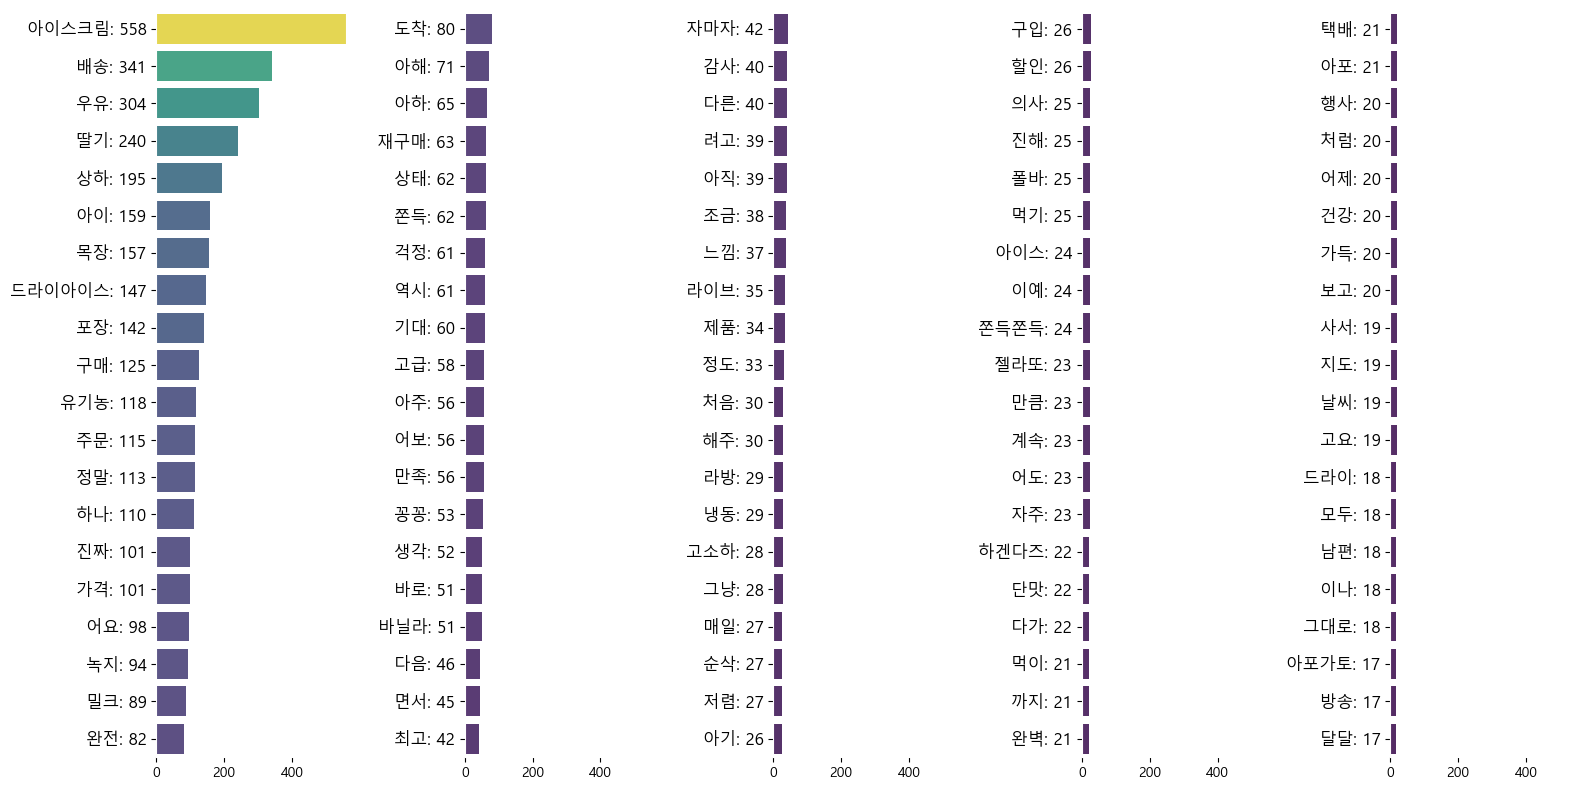

In [24]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df1_wordcount['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,5), index_list):
    df_temp = df1_wordcount[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df_temp['words'],df_temp['count'])]
    color_l = [color_dict.get(i) for i in df_temp['count']]
    x = list(df_temp['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df_temp, alpha=0.9, orient = 'h', ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.tight_layout()    
plt.show()

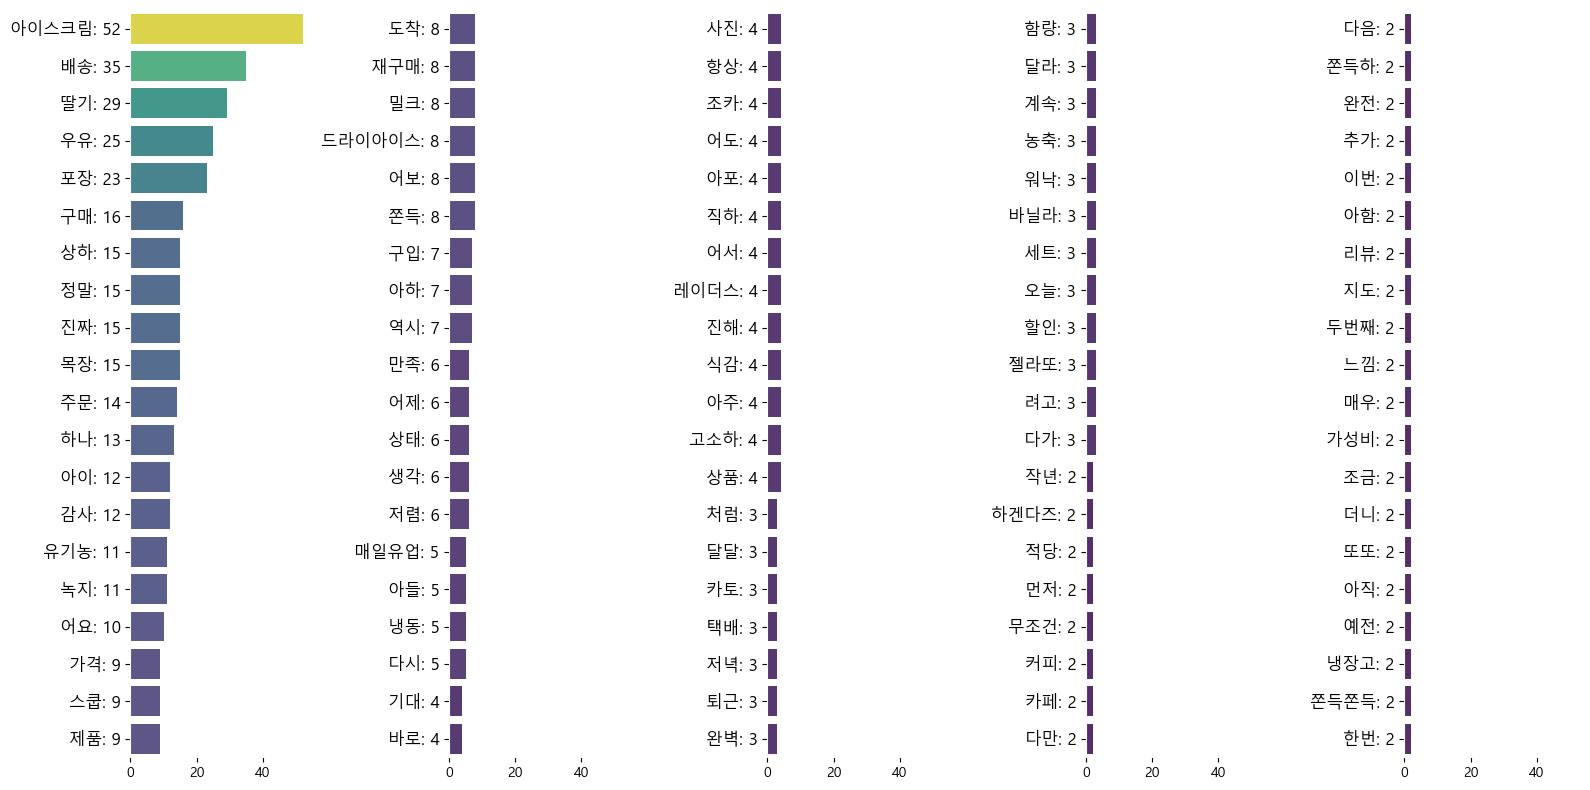

In [25]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df2_wordcount['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,5), index_list):
    df_temp = df2_wordcount[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df_temp['words'],df_temp['count'])]
    color_l = [color_dict.get(i) for i in df_temp['count']]
    x = list(df_temp['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df_temp, alpha=0.9, orient = 'h', ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.tight_layout()    
plt.show()

In [27]:
df3 = df1.copy()

In [40]:
df3 = df3[df3['리뷰등록일2'] == "2022-04"].reset_index(drop=True)

In [41]:
doc3 = listToString(df3[df3['리뷰상세내용'].str.contains(' ')]['리뷰상세내용'])
tokenized_doc3 = twitter.nouns(doc3)

for word in tokenized_doc3:  # iterating on a copy since removing will mess things up
    if word in stopwords:
        tokenized_doc3.remove(word)
        
wordfreq = {}
for word in listToString(tokenized_doc3).replace(', ',' ').split():
    wordfreq[word] = wordfreq.setdefault(word, 0) + 1
    
df3_wordcount = pd.DataFrame.from_dict([wordfreq]).T.reset_index()
df3_wordcount.rename(columns = {0 : 'count', 'index' : 'words'}, inplace =True)
df3_wordcount = df3_wordcount.sort_values(by = 'count', axis=0, ascending=False).reset_index()
df3_wordcount = df3_wordcount[['words', 'count']]

df3_wordcount['LEN'] = df3_wordcount['words'].str.len()
df3_wordcount = df3_wordcount[df3_wordcount['LEN'] >= 2]

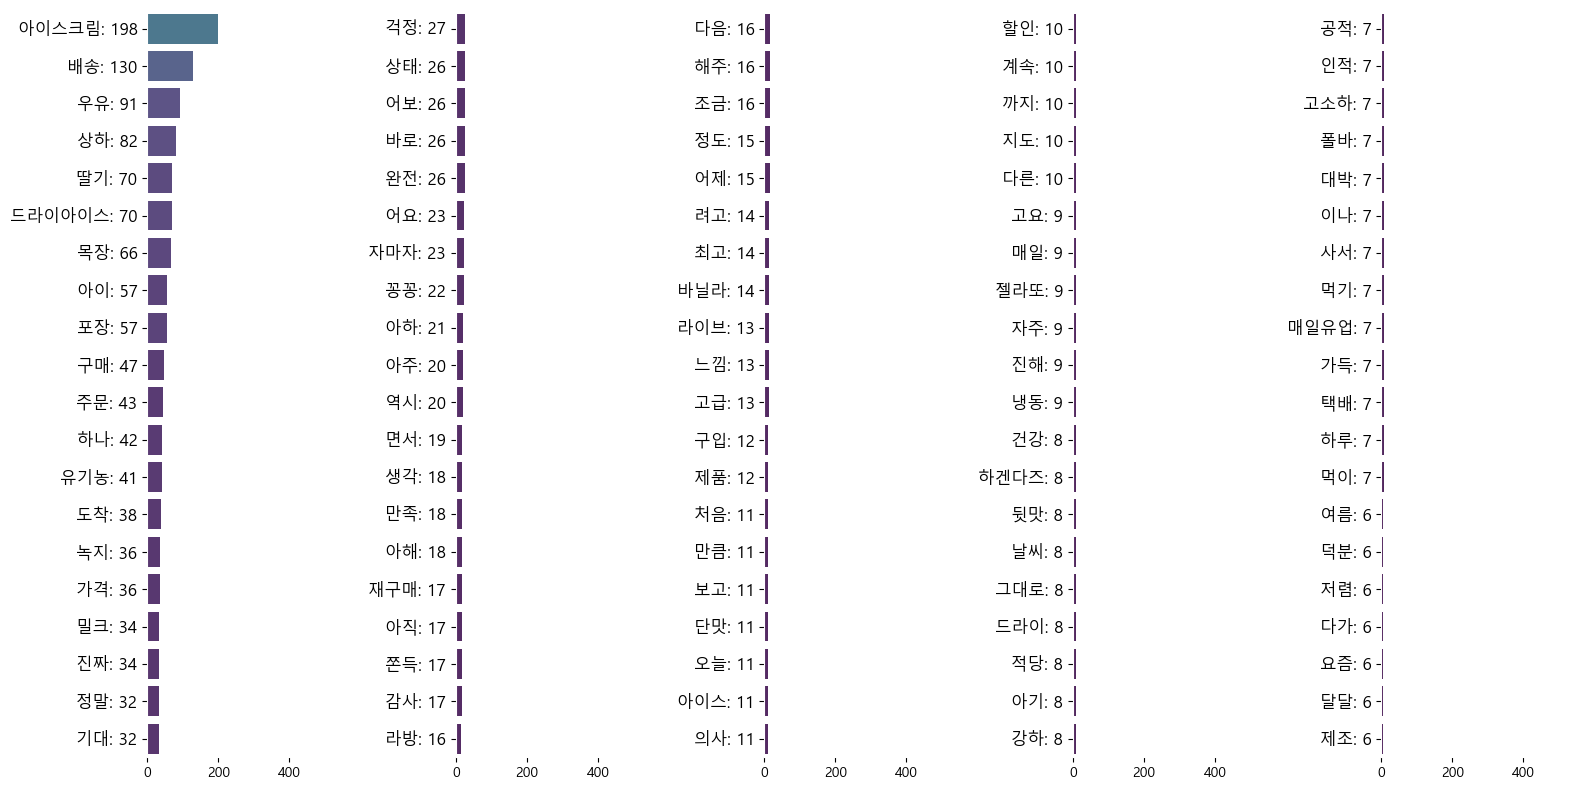

In [42]:
#create index list for slicing
index_list = [[i[0],i[-1]+1] for i in np.array_split(range(100), 5)]

n = df1_wordcount['count'].max()
color_dict = get_colordict('viridis', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16,8), facecolor='white', squeeze=False)
for col, idx in zip(range(0,5), index_list):
    df_temp = df3_wordcount[idx[0]:idx[-1]]
    label = [w + ': ' + str(n) for w,n in zip(df_temp['words'],df_temp['count'])]
    color_l = [color_dict.get(i) for i in df_temp['count']]
    x = list(df_temp['count'])
    y = list(range(0,20))
    
    sns.barplot(x = x, y = y, data=df_temp, alpha=0.9, orient = 'h', ax = axs[0][col], palette = color_l)
    axs[0][col].set_xlim(0,n+1)                     #set X axis range max
    axs[0][col].set_yticklabels(label, fontsize=12)
    axs[0][col].spines['bottom'].set_color('white')
    axs[0][col].spines['right'].set_color('white')
    axs[0][col].spines['top'].set_color('white')
    axs[0][col].spines['left'].set_color('white')
            
plt.tight_layout()    
plt.show()